In [11]:
from data_mining import data
d=data()

11it [00:11,  1.09s/it]


In [12]:
dataset=d.merge_whole_dataset()

100%|██████████| 14/14 [00:00<00:00, 137.31it/s]


In [13]:
dataset[dataset["Country_Region"]=="China"]

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,Shortcut,Population_using_at_least_basic_sanitation_services_(%),Hospital_beds_(per_10_000_population),Total_expenditure_on_health_as_a_percentage_of_gross_domestic_product,...,Skilled_health_professionals_density_(per_10_000_population),Prevalence_of_smoking_any_tobacco_product_among_persons_aged_>=_15_years,Raised_fasting_blood_glucose_(>=7.0_mmol/L_or_on_medication)(age-standardized_estimate),Raised_blood_pressure_(SBP>=140_OR_DBP>=90)_(age-standardized_estimate),"Prevalence_of_obesity_among_adults,_BMI_>=_30_(age-standardized_estimate)_(%)",Health_Service_Provision,Population ages 65 and above,Pop,Pop_dens,StringencyIndex
3185,4901,Anhui,China,2020-01-22,1,0,CHN,90.79677,42.0,5.54823,...,59.67,1.1,8.8,19.2,5.9,80.0,10.920884,1.392730e+09,148.348833,19.0
3186,4902,Anhui,China,2020-01-23,9,0,CHN,90.79677,42.0,5.54823,...,59.67,1.1,8.8,19.2,5.9,80.0,10.920884,1.392730e+09,148.348833,43.0
3187,4903,Anhui,China,2020-01-24,15,0,CHN,90.79677,42.0,5.54823,...,59.67,1.1,8.8,19.2,5.9,80.0,10.920884,1.392730e+09,148.348833,43.0
3188,4904,Anhui,China,2020-01-25,39,0,CHN,90.79677,42.0,5.54823,...,59.67,1.1,8.8,19.2,5.9,80.0,10.920884,1.392730e+09,148.348833,43.0
3189,4905,Anhui,China,2020-01-26,60,0,CHN,90.79677,42.0,5.54823,...,59.67,1.1,8.8,19.2,5.9,80.0,10.920884,1.392730e+09,148.348833,71.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5325,8161,Zhejiang,China,2020-03-22,1238,1,CHN,90.79677,42.0,5.54823,...,59.67,1.1,8.8,19.2,5.9,80.0,10.920884,1.392730e+09,148.348833,NaN
5326,8162,Zhejiang,China,2020-03-23,1238,1,CHN,90.79677,42.0,5.54823,...,59.67,1.1,8.8,19.2,5.9,80.0,10.920884,1.392730e+09,148.348833,NaN
5327,8163,Zhejiang,China,2020-03-24,1240,1,CHN,90.79677,42.0,5.54823,...,59.67,1.1,8.8,19.2,5.9,80.0,10.920884,1.392730e+09,148.348833,NaN
5328,8164,Zhejiang,China,2020-03-25,1241,1,CHN,90.79677,42.0,5.54823,...,59.67,1.1,8.8,19.2,5.9,80.0,10.920884,1.392730e+09,148.348833,NaN


In [14]:
germany = dataset[dataset["Country_Region"]=="Germany"]

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import datetime
from datetime import timedelta

%matplotlib inline

In [16]:
def plot_model_and_predict(data, pop, solution, title='SEIR model'):
    sus, exp, inf, rec = solution.y
    
    f = plt.figure(figsize=(16,5))
    ax = f.add_subplot(1,2,1)
    #ax.plot(sus, 'b', label='Susceptible');
    ax.plot(exp, 'y', label='Exposed');
    ax.plot(inf, 'r', label='Infected');
    ax.plot(rec, 'c', label='Recovered/deceased');
    plt.title(title)
    plt.xlabel("Days", fontsize=10);
    plt.ylabel("Fraction of population", fontsize=10);
    plt.legend(loc='best');
    
    ax2 = f.add_subplot(1,2,2)
    preds = np.clip((inf + rec) * pop ,0,np.inf)
    ax2.plot(range(len(data)),preds[:len(data)],label = 'Predict ConfirmedCases')
    ax2.plot(range(len(data)),data['ConfirmedCases'])
    plt.title('Model predict and data')
    plt.ylabel("Population", fontsize=10);
    plt.xlabel("Days", fontsize=10);
    plt.legend(loc='best');

In [17]:
# Function code refernece from https://www.kaggle.com/anjum48/seir-model-with-intervention

# Susceptible equation
def dS_dt(S, I, R_t, T_inf):
    return -(R_t / T_inf) * I * S

# Exposed equation
def dE_dt(S, E, I, R_t, T_inf, T_inc):
    return (R_t / T_inf) * I * S - (T_inc**-1) * E

# Infected equation
def dI_dt(I, E, T_inc, T_inf):
    return (T_inc**-1) * E - (T_inf**-1) * I

# Recovered/Remove/deceased equation
def dR_dt(I, T_inf):
    return (T_inf**-1) * I

def SEIR_model(t, y, R_t, T_inf, T_inc):
    
    if callable(R_t):
        reproduction = R_t(t)
    else:
        reproduction = R_t
        
    S, E, I, R = y
    
    S_out = dS_dt(S, I, reproduction, T_inf)
    E_out = dE_dt(S, E, I, reproduction, T_inf, T_inc)
    I_out = dI_dt(I, E, T_inc, T_inf)
    R_out = dR_dt(I, T_inf)
    
    return [S_out, E_out, I_out, R_out]

In [18]:
def cumsum_signal(vec):
    temp_val = 0
    vec_new = []
    for i in vec:
        if i > temp_val:
            vec_new.append(i)
            temp_val = i
        else:
            vec_new.append(temp_val)
    return vec_new

In [19]:
datapath="../data/"
train = pd.read_csv(datapath + "train.csv")
test = pd.read_csv(datapath + "test.csv")
train['Date_datetime'] = train['Date'].apply(lambda x: (datetime.datetime.strptime(x, '%Y-%m-%d')))

#pop_info = pd.read_csv('/kaggle/input/covid19-population-data/population_data.csv')
#country_pop = pop_info.query('Type == "Country/Region"')
#province_pop = pop_info.query('Type == "Province/State"')
#country_lookup = dict(zip(country_pop['Name'], country_pop['Population']))
#province_lookup = dict(zip(province_pop['Name'], province_pop['Population']))

In [20]:
# Use a constant reproduction number
def eval_model_const(params, data, population, return_solution=False, forecast_days=0):
    R_0, cfr = params # Paramaters, R0 and cfr 
    N = population # Population of each country
    n_infected = data['ConfirmedCases'].iloc[0] # start from first comfirmedcase on dataset first date
    max_days = len(data) + forecast_days # How many days want to predict
    s, e, i, r = (N - n_infected)/ N, 0, n_infected / N, 0 #Initial stat for SEIR model
    
    # R0 become half after intervention days
    def time_varying_reproduction(t):
        if t > 80: # we set intervention days = 80
            return R_0 * 0.5
        else:
            return R_0
    
    # Solve the SEIR differential equation.
    #sol = solve_ivp(SEIR_model, [0, max_days], [s, e, i, r], args=(time_varying_reproduction, T_inf, T_inc),
    #                t_eval=np.arange(0, max_days))
    
    sol = solve_ivp(fun=lambda t,y:SEIR_model(t, y, time_varying_reproduction, T_inf, T_inc),
                     t_span=[0, max_days],y0=[s, e, i, r], t_eval=np.arange(max_days))
    
    #sol2 = solve_ivp(SEIR_model, [0, max_days], [a, b, c, d], args=(time_varying_reproduction, T_inf, T_inc), 
    #            t_eval=np.arange(max_days))
    
    
    
    sus, exp, inf, rec = sol.y
    # Predict confirmedcase
    y_pred_cases = np.clip((inf + rec) * N ,0,np.inf)
    y_true_cases = data['ConfirmedCases'].values
    
    # Predict Fatalities by remove * fatality rate(cfr)
    y_pred_fat = np.clip(rec*N* cfr, 0, np.inf)
    y_true_fat = data['Fatalities'].values
    
    optim_days = min(20, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
    
    # using mean squre log error to evaluate
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    msle_final = np.mean([msle_cases, msle_fat])
    
    if return_solution:
        return msle_final, sol
    else:
        return msle_final

In [25]:
from matplotlib import dates
import plotly.graph_objects as go

def fit_model_new(data, area_name, initial_guess=[2.2, 0.02, 2, 50], 
              bounds=((1, 20), (0, 0.15), (1, 3), (1, 100)), make_plot=True, decay_mode = None):
    
    if area_name in ['France']:# France last data looks weird, remove it
        train_data = data.query('ConfirmedCases > 0').copy()[:-1]
    else:
        train_data = data.query('ConfirmedCases > 0').copy()
        
    ####### If this country have no ConfirmedCase, return 0 #######
    if len(train_data) == 0:
        result_zero = np.zeros((43))
        return pd.DataFrame({'ConfirmedCases':result_zero,'Fatalities':result_zero}), 0 
    
    ####### Load the population of area #######
    #try:
        #population = province_lookup[area_name]
    #    population = pop_info[pop_info['Name']==area_name]['Population'].tolist()[0]
    #except IndexError:
    #    print ('country not in population set, '+str(area_name))
    #    population = 1000000 
    
    
    #if area_name == 'US':
    population = 82200000
        
    cases_per_million = train_data['ConfirmedCases'].max() * 10**6 / population
    n_infected = train_data['ConfirmedCases'].iloc[0]
    
    ####### Total case/popuplation below 1, reduce country population #######
    if cases_per_million < 1:
        #print ('reduce pop divide by 100')
        population = population/100
        
    ####### Fit the real data by minimize the MSLE #######
    res_const = minimize(eval_model_const, [2.2, 0.02], bounds=((1, 20), (0, 0.15)),
                         args=(train_data, population, False),
                         method='L-BFGS-B')

    #res_decay = minimize(eval_model_decay, initial_guess, bounds=bounds,
    #                     args=(train_data, population, False),
    #                     method='L-BFGS-B')
    
    ####### Align the date information #######
    test_end = datetime.datetime.strptime('2020-04-30','%Y-%m-%d')
    test_start = datetime.datetime.strptime('2020-03-12','%Y-%m-%d')
    train_max = train_data.Date_datetime.max()
    train_min = train_data.Date_datetime.min()
    add_date = 0
    delta_days =(test_end - train_max).days
    train_add_time=[]

    if train_min > test_start:
        add_date = (train_min-test_start).days
        last = train_min-timedelta(add_date)
        train_add_time = np.arange(last, train_min, dtype='datetime64[D]').tolist()
        train_add_time = pd.to_datetime(train_add_time)
        dates_all = train_add_time.append(pd.to_datetime(np.arange(train_min, test_end+timedelta(1), dtype='datetime64[D]')))
    else:
        dates_all = pd.to_datetime(np.arange(train_min, test_end+timedelta(1), dtype='datetime64[D]'))


    ####### Auto find the best decay function ####### 
   #if decay_mode is None:
   #    if res_const.fun < res_decay.fun :
    msle, sol = eval_model_const(res_const.x, train_data, population, True, delta_days+add_date)
    res = res_const

   #    else:
   #        msle, sol = eval_model_decay(res_decay.x, train_data, population, True, delta_days+add_date)
   #        res = res_decay
   #        R_0, cfr, k, L = res.x
   #else:
   #    if decay_mode =='day_decay':
   #        msle, sol = eval_model_const(res_const.x, train_data, population, True, delta_days+add_date)
   #        res = res_const
   #    else:
   #        msle, sol = eval_model_decay(res_decay.x, train_data, population, True, delta_days+add_date)
   #        res = res_decay
   #        R_0, cfr, k, L = res.x

    ####### Predict the result by using best fit paramater of SEIR model ####### 
    sus, exp, inf, rec = sol.y
    
    y_pred = pd.DataFrame({
        'ConfirmedCases': cumsum_signal((np.clip((inf + rec) * population,0,np.inf)).tolist()),
       # 'ConfirmedCases': [inf[0]*population for i in range(add_date)]+(np.clip((inf + rec) * population,0,np.inf)).tolist(),
       # 'Fatalities': [rec[0]*population for i in range(add_date)]+(np.clip(rec, 0, np.inf) * population * res.x[1]).tolist()
        'Fatalities': cumsum_signal((np.clip(rec * population * res.x[1], 0, np.inf)).tolist())
    })

    y_pred_valid = y_pred.iloc[:len(train_data)]
    y_pred_test = y_pred.iloc[-43:]
    y_true_valid = train_data[['ConfirmedCases', 'Fatalities']]
    
    ####### Calculate MSLE ####### 
    valid_msle_cases = mean_squared_log_error(y_true_valid['ConfirmedCases'], y_pred_valid['ConfirmedCases'])
    valid_msle_fat = mean_squared_log_error(y_true_valid['Fatalities'], y_pred_valid['Fatalities'])
    valid_msle = np.mean([valid_msle_cases, valid_msle_fat])
    
    ####### Plot the fit result of train data and forecast after 300 days ####### 
    if make_plot:
        if len(res.x)<=2:
            print(f'Validation MSLE: {valid_msle:0.5f}, using intervention days decay, Reproduction number(R0) : {res.x[0]:0.5f}, Fatal rate : {res.x[1]:0.5f}')
        else:
            print(f'Validation MSLE: {valid_msle:0.5f}, using Hill decay, Reproduction number(R0) : {res.x[0]:0.5f}, Fatal rate : {res.x[1]:0.5f}, K : {res.x[2]:0.5f}, L: {res.x[3]:0.5f}')
        
        ####### Plot the fit result of train data dna SEIR model trends #######

        f = plt.figure(figsize=(16,5))
        ax = f.add_subplot(1,2,1)
        ax.plot(exp, 'y', label='Exposed');
        ax.plot(inf, 'r', label='Infected');
        ax.plot(rec, 'c', label='Recovered/deceased');
        plt.title('SEIR Model Trends')
        plt.xlabel("Days", fontsize=10);
        plt.ylabel("Fraction of population", fontsize=10);
        plt.legend(loc='best');
        
        #train_date_remove_year = train_data['Date_datetime'].apply(lambda date:'{:%m-%d}'.format(date))
        ax2 = f.add_subplot(1,2,2)
        xaxis = train_data['Date_datetime'].tolist()
        xaxis = dates.date2num(xaxis)
        hfmt = dates.DateFormatter('%m\n%d')
        ax2.xaxis.set_major_formatter(hfmt)
        ax2.plot(np.array(train_data['Date_datetime'], dtype='datetime64[D]'),train_data['ConfirmedCases'],label='Confirmed Cases (train)', c='g')
        ax2.plot(np.array(train_data['Date_datetime'], dtype='datetime64[D]'), y_pred['ConfirmedCases'][:len(train_data)],label='Cumulative modeled infections', c='r')
        plt.title('Real ConfirmedCase and Predict ConfirmedCase')
        plt.legend(loc='best');
        plt.show()
            
        ####### Forecast 300 days after by using the best paramater of train data #######
        if len(res.x)>2:
            msle, sol = eval_model_decay(res.x, train_data, population, True, 300)
        else:
            msle, sol = eval_model_const(res.x, train_data, population, True, 300)
        
        sus, exp, inf, rec = sol.y
        
        y_pred = pd.DataFrame({
            'ConfirmedCases': cumsum_signal(np.diff((inf + rec) * population, prepend=n_infected).cumsum()),
            'Fatalities': cumsum_signal(np.clip(rec, 0, np.inf) * population * res.x[1])
        })
        
        ####### Plot 300 days after of each country #######
        start = train_min
        end = start + timedelta(len(y_pred))
        time_array = np.arange(start, end, dtype='datetime64[D]')

        max_day = np.where(inf == np.amax(inf))[0][0]
        where_time = time_array[max_day]
        pred_max_day = y_pred['ConfirmedCases'][max_day]
        xy_show_max_estimation = (where_time, max_day)
        
        con = y_pred['ConfirmedCases']
        max_day_con = np.where(con == np.amax(con))[0][0] # Find the max confimed case of each country
        max_con = np.amax(con)
        where_time_con = time_array[len(time_array)-50]
        xy_show_max_estimation_confirmed = (where_time_con, max_con)
        
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=time_array, y=y_pred['ConfirmedCases'].astype(int),
                            mode='lines',
                            line = dict(color='red'),
                            name='Estimation Confirmed Case Start from '+ str(start.date())+ ' to ' +str(end.date())))
        fig.add_trace(go.Scatter(x=time_array[:len(train_data)], y=train_data['ConfirmedCases'],
                            mode='lines',
                            name='Confirmed case until '+ str(train_max.date()),line = dict(color='green', width=4)))
        fig.add_annotation(
            x=where_time_con,
            y=max_con-(max_con/30),
            showarrow=False,
            text="Estimate Max Case around:" +str(int(max_con)),
            font=dict(
                color="Blue",
                size=15
            ))
        fig.add_annotation(
            x=time_array[len(train_data)-1],
            y=train_data['ConfirmedCases'].tolist()[-1],
            showarrow=True,
            text=f"Real Max ConfirmedCase: " +str(int(train_data['ConfirmedCases'].tolist()[-1]))) 
        
        fig.add_annotation(
            x=where_time,
            y=pred_max_day,
            text='Infect start decrease from: ' + str(where_time))   
        fig.update_layout(title='Estimate Confirmed Case ,'+area_name+' Total population ='+ str(int(population)), legend_orientation="h")
        fig.show()
        
        #df = pd.DataFrame({'Values': train_data['ConfirmedCases'].tolist()+y_pred['ConfirmedCases'].tolist(),'Date_datatime':time_array[:len(train_data)].tolist()+time_array.tolist(),
        #           'Real/Predict': ['ConfirmedCase' for i in range(len(train_data))]+['PredictCase' for i in range(len(y_pred))]})
        #fig = px.line(df, x="Date_datatime", y="Values",color = 'Real/Predict')
        #fig.show()
        #plt.figure(figsize = (16,7))
        #plt.plot(time_array[:len(train_data)],train_data['ConfirmedCases'],label='Confirmed case until '+ str(train_max.date()),color='g', linewidth=3.0)
        #plt.plot(time_array,y_pred['ConfirmedCases'],label='Estimation Confirmed Case Start from '+ str(start.date())+ ' to ' +str(end.date()),color='r', linewidth=1.0)
        #plt.annotate('Infect start decrease from: ' + str(where_time), xy=xy_show_max_estimation, size=15, color="black")
        #plt.annotate('max Confirmedcase: ' + str(int(max_con)), xy=xy_show_max_estimation_confirmed, size=15, color="black")
        #plt.title('Estimate Confirmed Case '+area_name+' Total population ='+ str(int(population)))
        #plt.legend(loc='lower right')
        #plt.show()


    return y_pred_test, valid_msle

Validation MSLE: 1.00564, using intervention days decay, Reproduction number(R0) : 2.93452, Fatal rate : 0.00567


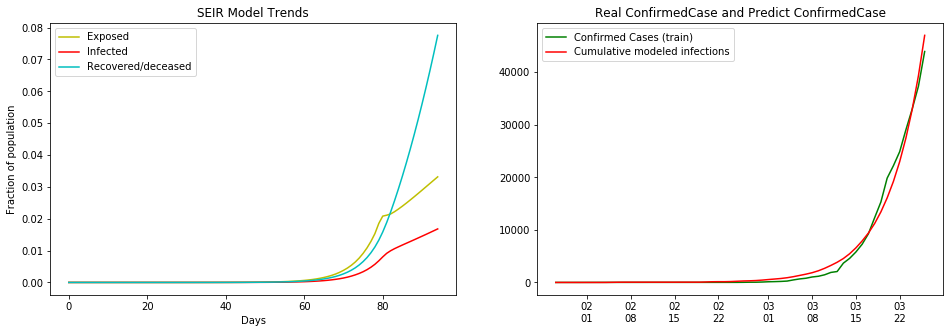

In [26]:
T_inc = 5.2  # average incubation period
T_inf = 2.9  # average infectious period
R_0 = 2.2  # reproduction number without intervention
R_t = 0.7  # reproduction number after intervention

country = 'Germany'

if country not in train['Country_Region'].unique():
    country_pd_train = train[train['Province_State']==country]
else:
    country_pd_train = train[train['Country_Region']==country]

a,b = fit_model_new(country_pd_train,country,make_plot=True)

In [ ]:
N = germany["Pop"][7870]  # Population size
print(N)
n_infected = germany["ConfirmedCases"][7876]
print(n_infected)
max_days = 200 #germany["Date"][7929]-germany["Date"][7870]
print(max_days)

# State at time = 0 for SEIR model
a = (N - n_infected)/ N
b = 0
c = n_infected / N
d = 0.

T_inc = 5.2  # average incubation period
T_inf = 2.9  # average infectious period

In [ ]:
# Use a constant reproduction number
def eval_model_const(params, data, population, return_solution=False, forecast_days=0):
    R_0, cfr = params
    N = population
    n_infected = data['ConfirmedCases'].iloc[0]
    max_days = len(data) + forecast_days
    a, b, c, d = (N - n_infected)/ N, 0, n_infected / N, 0
               
    sol = solve_ivp(SEIR_model, [0, max_days], [a, b, c, d], args=(R_0, T_inf, T_inc),
                    t_eval=np.arange(0, max_days))
    
    y_pred_cases = np.diff((sol.y[2] + sol.y[3])*N, prepend=n_infected).cumsum()
    y_pred_cases = np.clip(y_pred_cases, 0, np.inf)
    y_true_cases = data['ConfirmedCases'].values
    y_pred_fat = np.clip(sol.y[3]*N, 0, np.inf) * cfr
    y_true_fat = data['Fatalities'].values
    
    optim_days = min(14, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
    
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    msle_final = np.mean([msle_cases, msle_fat])
    
    if return_solution:
        return msle_final, sol
    else:
        return msle_final

In [31]:
ydata = [i for i in germany.ConfirmedCases['sum'].values]
xdata = germany.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

def fit_odeint(t, R_t, T_inf, T_inc)
    return integrate.odeint(SEIR_model, (t, y, R_0, T_inf, T_inc), x, args=(R_0))[:,5]

r_est = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata,r_est)

[[ 8.29279120e+07  8.29279042e+07  8.29278831e+07  8.29278627e+07
   8.29278573e+07  8.29278705e+07  8.29278951e+07  8.29279138e+07
   8.29278985e+07  8.29278503e+07  8.29278197e+07  8.29278268e+07
   8.29278537e+07  8.29278446e+07  8.29277767e+07  8.29277229e+07
   8.29277214e+07  8.29277614e+07  8.29277835e+07  8.29277112e+07
   8.29276246e+07  8.29275860e+07  8.29275929e+07  8.29275823e+07
   8.29274857e+07  8.29273850e+07  8.29273242e+07  8.29272950e+07
   8.29272380e+07  8.29270957e+07  8.29269443e+07  8.29268294e+07
   8.29267440e+07  8.29266295e+07  8.29264080e+07  8.29261500e+07
   8.29259231e+07  8.29257298e+07  8.29255098e+07  8.29251541e+07
   8.29247082e+07  8.29242748e+07  8.29238738e+07  8.29234441e+07
   8.29228501e+07  8.29221115e+07  8.29213353e+07  8.29205282e+07
   8.29196228e+07  8.29185147e+07  8.29172601e+07  8.29158897e+07
   8.29143788e+07  8.29126541e+07  8.29106464e+07  8.29083918e+07
   8.29058938e+07  8.29031095e+07  8.28999505e+07  8.28963029e+07
   8.28921

   6.98750175e+07  6.98839320e+07  6.98920191e+07  6.98993540e+07]]


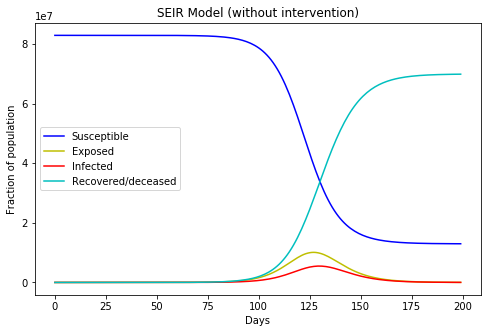

In [39]:
T_inc = 5.2  # average incubation period
T_inf = 2.9  # average infectious period
R_0 = 2.2  # reproduction number

#sol = solve_ivp(SEIR_model, [0, max_days], [a, b, c, d], args=(R_0, T_inf, T_inc), 
#                t_eval=np.arange(max_days))
sol = solve_ivp(fun=lambda t,y:SEIR_model(t, y, R_0, T_inf, T_inc),t_span=[0, max_days],y0=[a, b, c, d], t_eval=np.arange(max_days))

sol["y"] = sol["y"]*N
print(sol["y"])

plot_model(sol, 'SEIR Model (without intervention)')

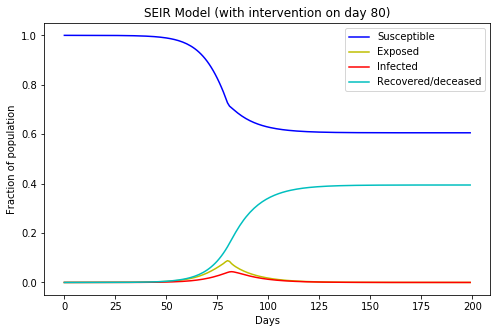

In [38]:
T_inc = 5.2  # average incubation period
T_inf = 2.9  # average infectious period
R_0 = 2.2  # reproduction number without intervention
R_t = 0.7  # reproduction number after intervention
intervention_day = 80

def time_varying_reproduction(t):
    if t > intervention_day:
        return R_t
    else:
        return R_0

sol2 = solve_ivp(fun=lambda t,y:SEIR_model(t, y, time_varying_reproduction, T_inf, T_inc),t_span=[0, max_days],y0=[a, b, c, d], t_eval=np.arange(max_days))

plot_model(sol2, f'SEIR Model (with intervention on day {intervention_day})')

In [ ]:
# Use a constant reproduction number
def eval_model_const(params, data, population, return_solution=False, forecast_days=0):
    R_0, cfr = params
    N = population
    n_infected = data['ConfirmedCases'].iloc[0]
    max_days = len(data) + forecast_days
    a, b, c, d = (N - n_infected)/ N, 0, n_infected / N, 0
               
    sol2 = solve_ivp(fun=lambda t,y:SEIR_model(t, y, time_varying_reproduction, T_inf, T_inc),t_span=[0, max_days],y0=[a, b, c, d], t_eval=np.arange(max_days))
    
    y_pred_cases = np.diff((sol.y[2] + sol.y[3])*N, prepend=n_infected).cumsum()
    y_pred_cases = np.clip(y_pred_cases, 0, np.inf)